In [35]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [36]:
df=pd.read_csv("diabetic_data.csv")
#df
#df.info()

In [37]:
#1. #shape of dataframe and replace all missing values by nan values
df.shape
df = df.replace('?', np.NaN)

In [38]:
#2. #column having more than 50% os muissing values

percent_missing = (df.isnull().sum() * 100) / len(df)
for index, value in percent_missing.items():
    if value > 50:
        df=df.drop(index,axis=1)

#2. # If 90% value keeps repeating drop that column alone
for Column_Name in df.columns:  
    for value in (df[Column_Name].value_counts() * 100 )/float(len(df)):       
        if value > 95:             
            df=df.drop(Column_Name,axis=1)  

In [39]:
#3. Transform the age to be the middle value in each given range
agelist=[]
for ageCell in df['age']: # this will give us tuple ( Row Number, Value)
    Numbers = re.findall('\d+', ageCell)
    agelist.append(((int(Numbers[0]) + int(Numbers[1]))) / 2)
df['age'] = agelist

In [40]:
#4. Replace Missing values denoted by ? to 0 in the below respective column
df.replace({'diag_1':{'?':0}},inplace=True)
df.replace({'diag_2':{'?':0}},inplace=True)
df.replace({'diag_3':{'?':0}},inplace=True)

In [41]:
#5.  Drop all rows with missing values  Ask anand..there is nothing to remove ..what are the other cases we might 
#consider a row with missing value in df
df.dropna(axis=0, how='any', inplace=True)

In [42]:
#6. Identify all numerical features and categorial data
categoryData = [Data for Data in df.columns if df[Data].dtype=='object']
numericalData = [Data for Data in df.columns if (df[Data].dtype=='int64') or (df[Data].dtype=='float64')]

In [52]:

#7. Identify outliers in the numerical columns and remove them.
# zscore standard deviated is meant for numerical daata not for categrical data  as we cannot plot a graph with boolean data
dfn = df[numericalData].astype(float)
z_scores = stats.zscore(dfn)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1) #return list of column having less than 3 standard divation
dfno = dfn[filtered_entries]
dfno.shape

(23043, 14)

In [64]:
#8 Drop duplicates and replace with the latest one 
dfno = dfno.drop_duplicates(subset=['patient_nbr'],keep='last')
dfno.shape

(17296, 14)

Text(0.5, 1.0, 'Age Of Patient VS Readmission ')

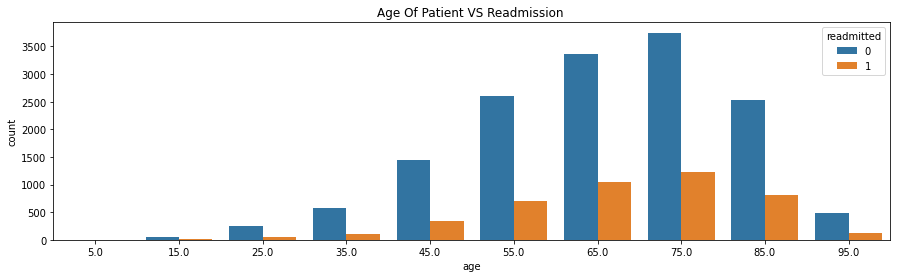

In [57]:
# TASK 2
#1. age vs readmission Age has a higher impact on readmission.
df['readmitted'] = ['1' if (i=='<30') | (i=='>30') else '0' if i=='NO' else i for i in df['readmitted'].tolist()]
fig = plt.figure(figsize=(15,4)) #Plot size
sns.countplot(x= df['age'], hue = df['readmitted']).set_title('Age Of Patient VS Readmission ')

<AxesSubplot:xlabel='race', ylabel='count'>

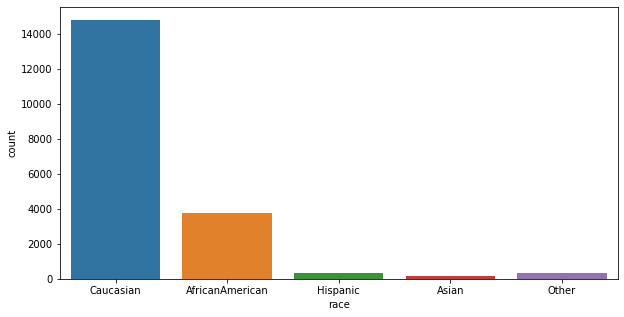

In [58]:
#2. African Americans are more likely to be re-admitted than other ethnic groups

fig = plt.figure(figsize=(10,5))
sns.countplot(x = df['race'],data= df)

Text(0.5, 1.0, 'Women Patients vs Men Patients Re-Admitted')

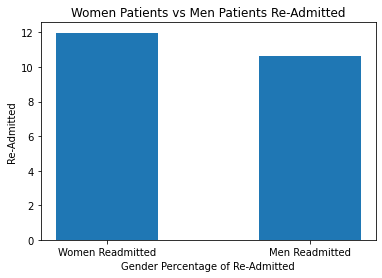

In [59]:
# Women patients are more likely to be re-admitted than men
#Male  1
#Female  0
#Add legends 
df['womenreadmitted'] = np.where((df['gender'] == 'Female') & (df['readmitted'] == "1"),1,0)
df['menreadmitted'] = np.where((df['gender'] == 'Male') & (df['readmitted'] == "1"),1,0)
    
womenReadmitted = df['womenreadmitted'].sum() * 100 / len(df['womenreadmitted'])
menReadmitted = df['menreadmitted'].sum() * 100 / len(df['menreadmitted'])

kinetic = "Women Readmitted", "Men Readmitted"
values = womenReadmitted , menReadmitted
test  = plt.bar(kinetic, values,  width = 0.5)
 

plt.xlabel("Gender Percentage of Re-Admitted")
plt.ylabel("Re-Admitted")
plt.title("Women Patients vs Men Patients Re-Admitted")


Text(0.5, 1.0, 'Age Of Patient VS Readmission ')

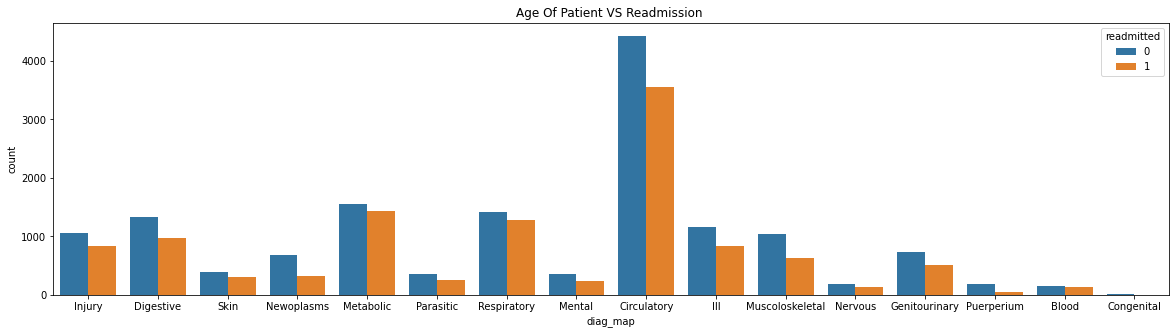

In [122]:
df_copy = df.copy()


diag_cols = 'diag_1'
df_copy[diag_cols] = df_copy[diag_cols].str.replace('E','-')
df_copy[diag_cols] = df_copy[diag_cols].str.replace('V','-')
condition = df_copy[diag_cols].str.contains('250') 
df_copy.loc[condition,diag_cols] = '250'
df_copy['diag_map']=np.nan
df_copy[diag_cols] = df_copy[diag_cols].astype(float)

def ModifyDiagColum(lowerInd , UpperInd, Type):
    condition = (df_copy['diag_1'] >= lowerInd) & (df_copy['diag_1'] <= UpperInd)
    df_copy.loc[condition,'diag_map']= Type


diagIcdList = [[1,139],[140,239],[240,279],[280,289],[290,319],[320,389],[390,459],[460,519],[520,579]
               ,[580,629],[630,679],[680,709],[710,739],[740,759],[760,779],[780,799],[800,999]]
diagIcdName = ['Parasitic','Newoplasms','Metabolic', 'Blood' , 'Mental' , 'Nervous', 'Circulatory' ,
               'Respiratory' ,'Digestive','Genitourinary','Puerperium','Skin','Muscoloskeletal','Congenital' ,
               'Perinatal', 'Ill', 'Injury']

for icd, Name in zip(diagIcdList,diagIcdName):
    ModifyDiagColum(icd[0], icd[1],Name)

fig = plt.figure(figsize=(20,5))
sns.countplot(x= df_copy['diag_map'], hue = df_copy['readmitted']).set_title('Age Of Patient VS Readmission ')

# Part 2 Model Building

# Declaring target vector and feature vector

In [71]:
#Model building
# Split the
#data into a training and test sets; build up the model
#target vector - output
#feature vector - indipendecnt vectors 

from sklearn.linear_model import LogisticRegression
df = df[['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital',
'number_inpatient', 'encounter_id', 'age', 'num_lab_procedures', 'number_diagnoses',
'num_procedures', 'readmitted']]

x = df.drop(['readmitted'] ,axis =1) #indepedent varible
y = df['readmitted'] #depedent variable

# Splitt data into seperate training and test set

In [99]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.2 )


In [100]:

cols = x_train.columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train) #scalling bring the value betwwen 0 -1
x_test = scaler.transform(x_test) #

x_train = pd.DataFrame(x_train, columns=[cols])
x_test = pd.DataFrame(x_test, columns=[cols])
x_train.describe()

,num_medications,number_outpatient,number_emergency,time_in_hospital,number_inpatient,encounter_id,age,num_lab_procedures,number_diagnoses,num_procedures
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000
mean,0.190551,0.013222,0.004718,0.248554,0.030287,0.318977,0.685082,0.335330,0.329173,0.253414
std,0.110188,0.046202,0.021358,0.227408,0.064501,0.240764,0.170805,0.165713,0.147823,0.296993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.112500,0.000000,0.000000,0.076923,0.000000,0.128030,0.555556,0.241667,0.153846,0.000000
50%,0.175000,0.000000,0.000000,0.153846,0.000000,0.249503,0.666667,0.350000,0.384615,0.166667
75%,0.237500,0.000000,0.000000,0.384615,0.062500,0.454650,0.777778,0.450000,0.461538,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Training

In [121]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(x_train.values, y_train.values)

LogisticRegression(random_state=0, solver='liblinear')

In [122]:
y_pred_test = logreg.predict(x_test.values)

In [123]:
logreg.predict_proba(x_test.values)[:,0]

array([0.63174008, 0.6553228 , 0.52767264, ..., 0.8813596 , 0.72420619,
       0.88132007])

In [124]:
logreg.predict_proba(x_test.values)[:,1]

array([0.36825992, 0.3446772 , 0.47232736, ..., 0.1186404 , 0.27579381,
       0.11867993])

In [111]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7757


In [118]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)

#cv=onfsuin matrix says how may rows satsifies each diff condiotns in the matric formate
#confsion matric defines the accuracy of the model in the matric form 

print('Confusion matrix\n\n', cm) 

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

73347    0
78958    0
95059    0
72380    0
36673    1
        ..
43443    0
81721    0
35557    0
39859    0
26082    0
Name: readmitted, Length: 3888, dtype: object
Confusion matrix

 [[2977   37]
 [ 835   39]]

True Positives(TP) =  2977

True Negatives(TN) =  39

False Positives(FP) =  37

False Negatives(FN) =  835


<AxesSubplot:>

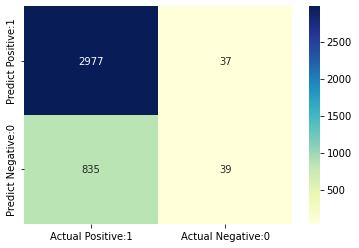

In [114]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [126]:
#cross-validation procedure.
# train segmebnt ed into 5 , antha 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, x_train.values, y_train.values, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print(scores.mean())


Cross-validation scores:[0.77427653 0.77299035 0.77684887 0.7778135  0.77902863]
0.7761915774036378
